Connected to MetaTrader 5


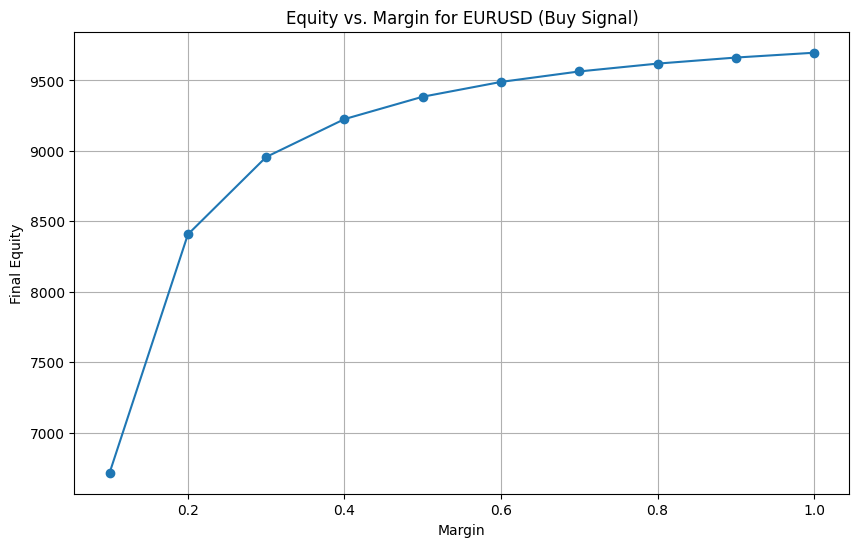

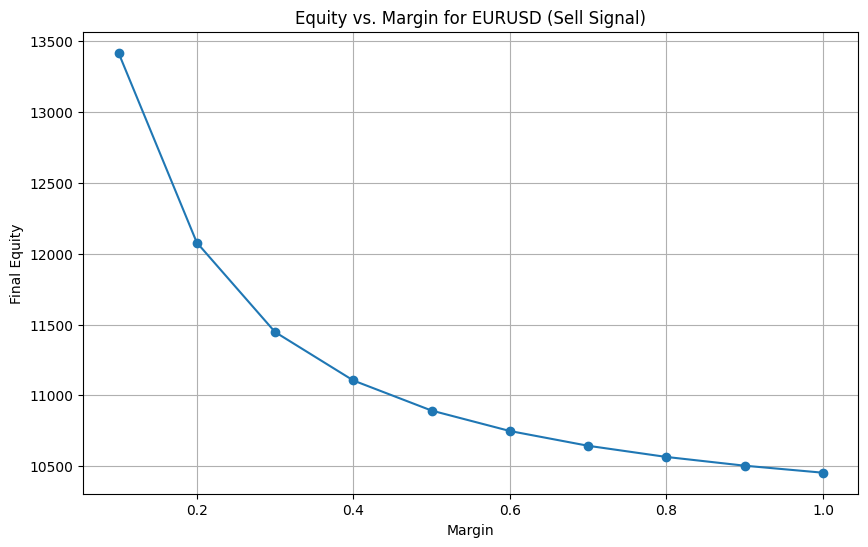

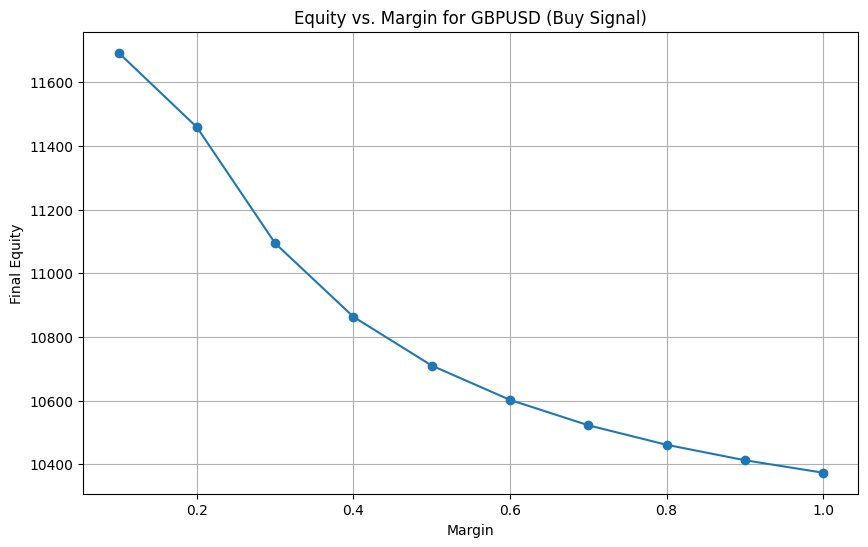

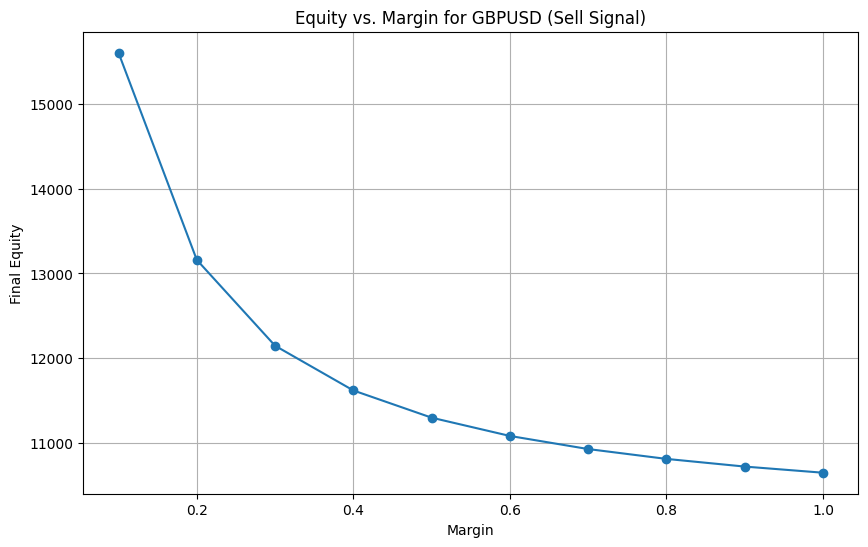

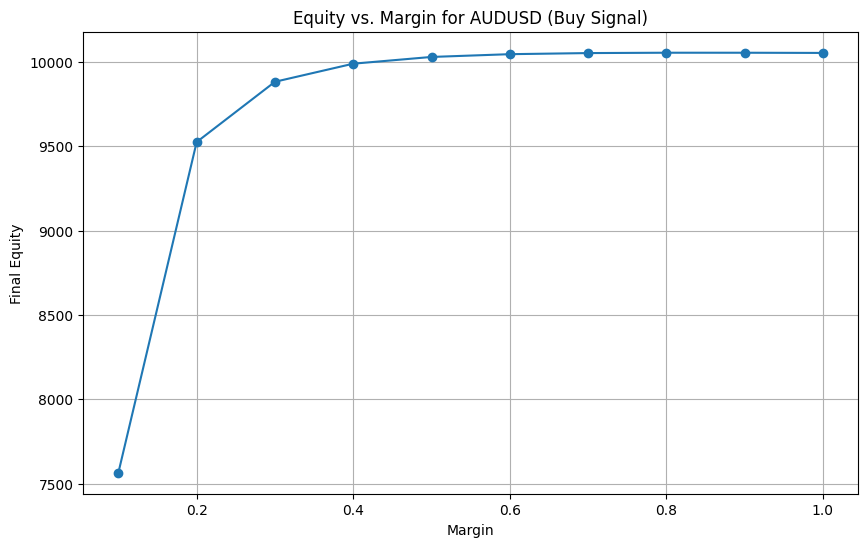

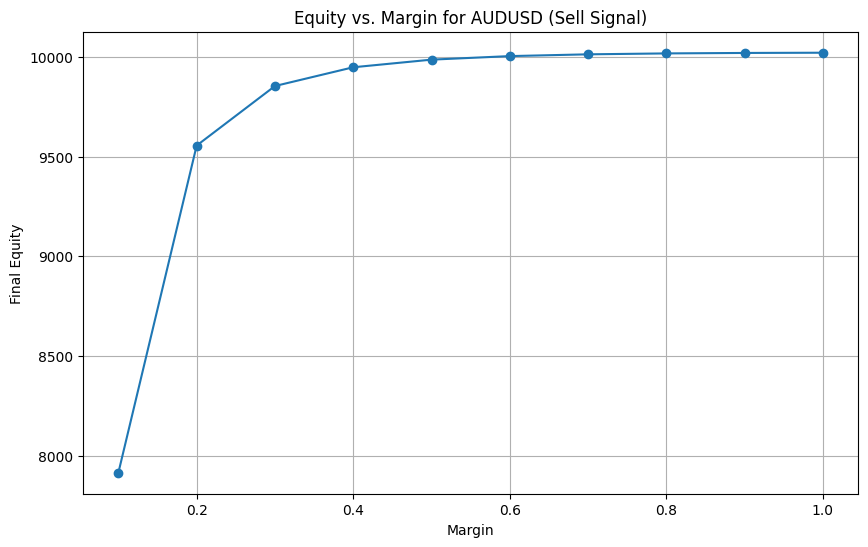

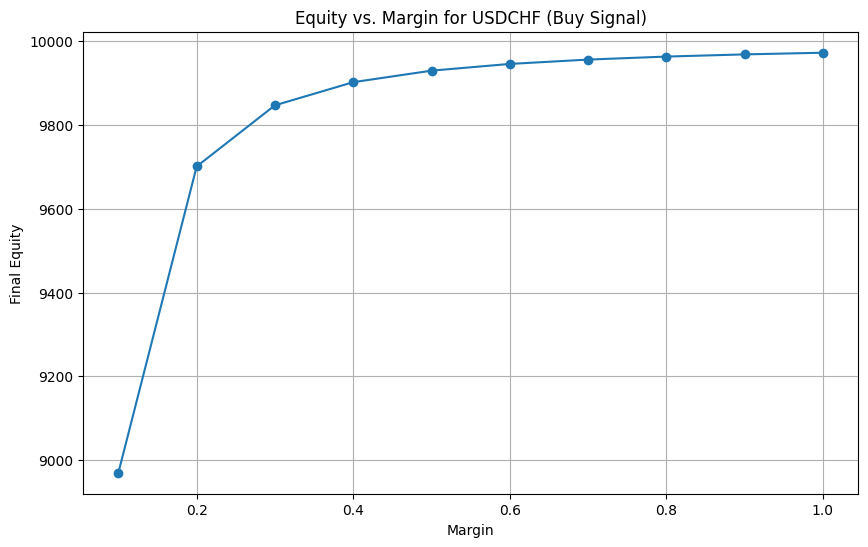

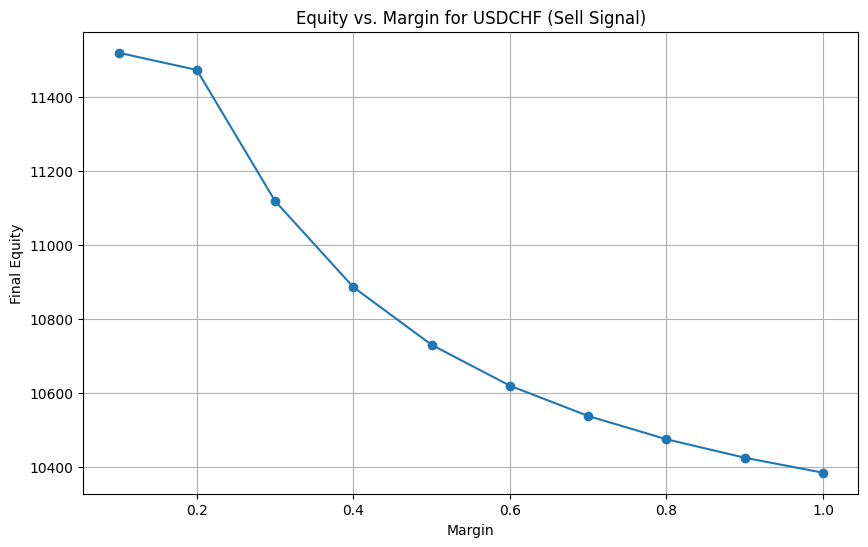

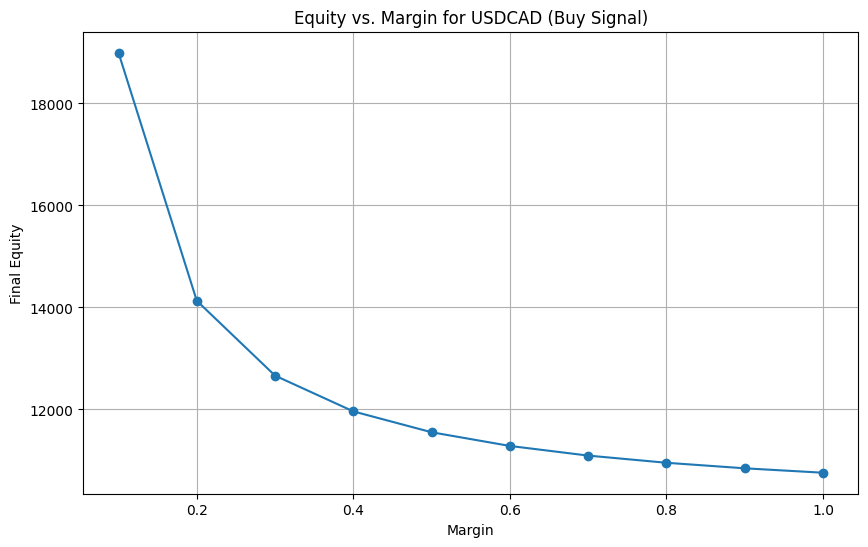

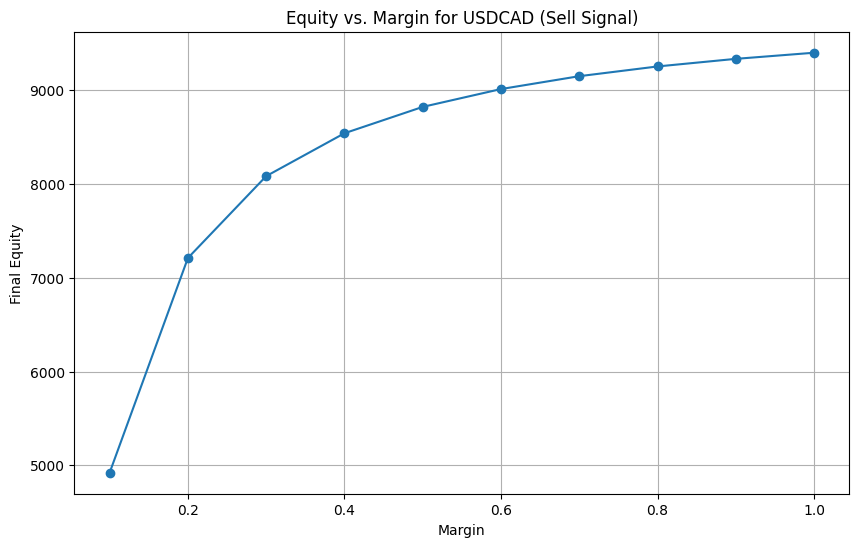

In [13]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(-1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        # Buy signal
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        # Sell signal
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Function to perform backtesting and return key metrics
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, signal_type, mean_candle_size, margin):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest with specified margin
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()
    
    # Return key performance metrics for analysis (adjust based on available keys)
    return {
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Margin": margin  # Include margin for reference
    }

""" # Main function to fetch OHLC data, align it with prediction data, and run backtest with varying margins
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009196304524519085,
            'buy_prediction_file': 'pred_EURUSD_Buy.csv',
            'sell_prediction_file': 'pred_EURUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011,
            'buy_prediction_file': 'pred_GBPUSD_Buy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0080,
            'buy_prediction_file': 'pred_AUDUSD_Buy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'USDCHF': {
            'symbol': 'USDCHF',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.007648387882066531,
            'buy_prediction_file': 'pred_USDCHF_Buy.csv',
            'sell_prediction_file': 'pred_USDCHF_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.2,
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': (1, 1),
            'sell_risk_reward_ratio': (2, 3),
            'margin': 0.1,
        }
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    #margin_values = [round(0.05 + i * 0.01, 2) for i in range(15)]  # Margin values from 0.05 to 0.2
    margin_values = [round(0.1 + i * 0.1, 2) for i in range(10)]

    # DataFrame to store results for better readability
    results_summary = []

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Run backtests for both Buy and Sell signals
        for signal_type, file_key, risk_reward_key in [('Buy', 'buy_prediction_file', 'buy_risk_reward_ratio'),
                                                       ('Sell', 'sell_prediction_file', 'sell_risk_reward_ratio')]:
            if pair_config[file_key]:
                ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config[file_key])
                if ohlc_data_with_predictions is not None:
                    best_result = None
                    for margin in margin_values:
                        stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, 
                                             pair_config[risk_reward_key], signal_type, 
                                             pair_config['mean_candle_size'], margin)
                        if best_result is None or stats["Final Equity"] > best_result["Final Equity"]:
                            best_result = stats
                    # Append best result for this signal and pair to the summary list
                    results_summary.append({
                        "Pair": pair_name,
                        "Signal": signal_type,
                        "Best Margin": best_result["Margin"],
                        "Final Equity": best_result["Final Equity"],
                        "Return (%)": best_result["Return (%)"],
                        "Max Drawdown (%)": best_result["Max Drawdown (%)"],
                        "Profit Factor": best_result["Profit Factor"],
                        "Sharpe Ratio": best_result["Sharpe Ratio"]
                    })

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results_summary)
    print("Backtest Results Summary:")
    print(results_df)

    mt5.shutdown()

 """

# Main function to fetch OHLC data, align it with prediction data, and run backtest with varying margins
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009196304524519085,
            'buy_prediction_file': 'pred_EURUSD_Buy.csv',
            'sell_prediction_file': 'pred_EURUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011,
            'buy_prediction_file': 'pred_GBPUSD_Buy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0080,
            'buy_prediction_file': 'pred_AUDUSD_Buy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
        },
        'USDCHF': {
            'symbol': 'USDCHF',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.007648387882066531,
            'buy_prediction_file': 'pred_USDCHF_Buy.csv',
            'sell_prediction_file': 'pred_USDCHF_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': (1, 1),
            'sell_risk_reward_ratio': (2, 3),
        }
    }

    # Initialize MetaTrader 5 connection
    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    # Margin values from 0.1 to 1.0 (inclusive)
    margin_values = [round(0.1 + i * 0.1, 2) for i in range(10)]

    # DataFrame to store all results
    all_results = []

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Run backtests for both Buy and Sell signals
        for signal_type, file_key, risk_reward_key in [('Buy', 'buy_prediction_file', 'buy_risk_reward_ratio'),
                                                       ('Sell', 'sell_prediction_file', 'sell_risk_reward_ratio')]:
            if pair_config[file_key]:
                ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config[file_key])
                if ohlc_data_with_predictions is not None:
                    # Iterate over all margin values and store results
                    for margin in margin_values:
                        stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, 
                                             pair_config[risk_reward_key], signal_type, 
                                             pair_config['mean_candle_size'], margin)
                        all_results.append({
                            "Pair": pair_name,
                            "Signal": signal_type,
                            "Margin": margin,
                            "Final Equity": stats["Final Equity"],
                            "Return (%)": stats["Return (%)"],
                            "Max Drawdown (%)": stats["Max Drawdown (%)"],
                            "Profit Factor": stats["Profit Factor"],
                            "Sharpe Ratio": stats["Sharpe Ratio"]
                        })

    # Convert all results to DataFrame and display
    results_df = pd.DataFrame(all_results)
    # Save results to CSV for further analysis
    results_df.to_csv("detailed_backtest_results.csv", index=False)

    # Plotting equity vs. margin for each pair and signal type
    for pair_name in results_df['Pair'].unique():
        for signal_type in ['Buy', 'Sell']:
            subset = results_df[(results_df['Pair'] == pair_name) & (results_df['Signal'] == signal_type)]
            plt.figure(figsize=(10, 6))
            plt.plot(subset['Margin'], subset['Final Equity'], marker='o')
            plt.title(f"Equity vs. Margin for {pair_name} ({signal_type} Signal)")
            plt.xlabel("Margin")
            plt.ylabel("Final Equity")
            plt.grid()
            plt.show()

    mt5.shutdown()


if __name__ == "__main__":
    main()


In [14]:
results = pd.read_csv("detailed_backtest_results.csv")

In [18]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False) 

print("Detailed Backtest Results:")
print(results)


Detailed Backtest Results:
      Pair Signal  Margin  Final Equity  Return (%)  Max Drawdown (%)  Profit Factor  Sharpe Ratio
0   EURUSD    Buy     0.1   6716.066508  -32.839335        -48.781153       0.913127      0.000000
1   EURUSD    Buy     0.2   8407.411492  -15.925885        -27.752483       0.913127      0.000000
2   EURUSD    Buy     0.3   8956.602462  -10.433975        -19.344694       0.913127      0.000000
3   EURUSD    Buy     0.4   9225.358430   -7.746416        -14.836631       0.913127      0.000000
4   EURUSD    Buy     0.5   9384.302459   -6.156975        -12.030034       0.913127      0.000000
5   EURUSD    Buy     0.6   9489.326371   -5.106736        -10.115294       0.913127      0.000000
6   EURUSD    Buy     0.7   9563.690853   -4.363091         -8.726107       0.913127      0.000000
7   EURUSD    Buy     0.8   9619.249112   -3.807509         -7.672190       0.913127      0.000000
8   EURUSD    Buy     0.9   9662.229829   -3.377702         -6.845189       0.8853